# Data Exploration

This notebook is meant to be a template for explorion of the data collected from trials.

### Please duplicate the notebook to start your work and keep the template intact.

## Before running the notebook
The trial datastore process must be started prior to running the notebook. Make sure you open a terminal, activate the .venv environment, run:
```
python -m launch_local_services
```

Once you are done with working in this notebook, close the terminal window.

## Cogment Setup

In [80]:
import os
import sys

ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), "../"))
sys.path.append(ROOT_DIR)

from cogment_verse.utils.generate import generate
from cogment_verse.app import SPEC_FILEPATH

WORK_DIR = os.path.join(ROOT_DIR, ".cogment_verse")

generate(WORK_DIR, SPEC_FILEPATH)

In [88]:
import asyncio
import functools
import re
from dataclasses import dataclass, field
from datetime import datetime
from typing import List

import cogment
import numpy as np
import pandas as pd
from cogment.control import TrialState
from tabulate import tabulate
from utils import get_trial_ids, get_trial_data


import matplotlib.pyplot as plt
import ipywidgets as widgets

import torch

from cogment_verse.specs import (
    AgentConfig,
    cog_settings,
    EnvironmentConfig,
    EnvironmentSpecs,
)
from cogment_verse.specs.ndarray_serialization import deserialize_ndarray, serialize_ndarray


TRIAL_DATASTORE_ENDPOINT = "grpc://localhost:9001"

## Extract trial ids from datastore

In [78]:
trial_ids = await get_trial_ids(TRIAL_DATASTORE_ENDPOINT)
print(f"Trial ids count: {len(trial_ids)}")
print(f"first 10 trial ids: [{', '.join(trial_ids[:10])}]")

Trial ids count: 3
first 10 trial ids: [vigilant_hermann_0_0, vigilant_hermann_0_1, vigilant_hermann_0_2]


## Extract Trial Data

Example extracting trial info and `samples` for all trials in the datastore.

If only interested in a single or specific set of trial ids, simply pass elements in the list argument `trial_ids` of the function `get_trial_data`.

In [83]:
trial_data = await get_trial_data(TRIAL_DATASTORE_ENDPOINT, trial_ids=[])
test_trial_id = "vigilant_hermann_0_0"

# Trial info about a specific trial ID
info = trial_data[test_trial_id]["trial_info"]

# List of samples for specific Trial ID
samples = trial_data[test_trial_id]["samples"]
print(f"Number of samples in trial: {len(samples)}")

environment_specs = EnvironmentSpecs.deserialize(info.parameters.actors[0].config.environment_specs)
action_space = environment_specs.get_action_space()
observation_space = environment_specs.get_observation_space()

Number of samples in trial: 2639


## Inspect Trial Data

Each trial comes with a set of generic information about the trial. It is an instance of `TrialInfo` class. 

For more information about the `TrialInfo` class, see https://cogment.ai/docs/reference/python#class-trialinfo. 

In [84]:
print(f"Trial ID: {info.trial_id}")
print(f"Trial State: {info.trial_state}")
print(f"Number of steps: {info.sample_count}")

print(f"Environment Implementation: {print(info.parameters.environment_implementation)}")
print(f"Environment Config: {info.parameters.environment_config}")

Trial ID: vigilant_hermann_0_0
Trial State: TrialState.ENDED
Number of steps: 2639
environments.pettingzoo_adapter.AtariEnvironment/pettingzoo.atari.pong_v3
Environment Implementation: None
Environment Config: run_id: "vigilant_hermann_0"
render: true



## Inspect Sample

Each sample from the trial datastore is an instance of the `DatastoreSample` class. 

For more info on the `DatastoreSample` class, see: https://cogment.ai/docs/reference/python#class-datastoresample




In [85]:
sample = samples[801]

def deserialize_sample(sample, actor_name, action_space, observation_space):
    cogment_obs = sample.actors_data[actor_name].observation
    cogment_action = sample.actors_data[actor_name].action
    name = sample.actors_data[actor_name].name
    reward = sample.actors_data[actor_name].reward
    observation = observation_space.deserialize(cogment_obs).value
    action = action_space.deserialize(cogment_action).value

    return name, observation, action, reward

# General Sample info
print(f"Trial ID: {sample.trial_id}")
print(f"Trial State: {sample.trial_state}")
print(f"Step: {sample.tick_id}")
print(f"Timestamp: {sample.timestamp}")
print(f"Actors: {list(sample.actors_data.keys())}")

name, observation, action, reward = deserialize_sample(sample, "web_actor", action_space, observation_space)

print(f"Observation shape: {observation.shape}")
print(f"Action: {action}")
print(f"Reward: {reward}")

Trial ID: vigilant_hermann_0_0
Trial State: TrialState.RUNNING
Step: 801
Timestamp: 1685054996685931861
Actors: ['web_actor', 'player_2']
Observation shape: (84, 84, 6)
Action: 0
Reward: 0.0


In [86]:
print(observation[:, :, 5])

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


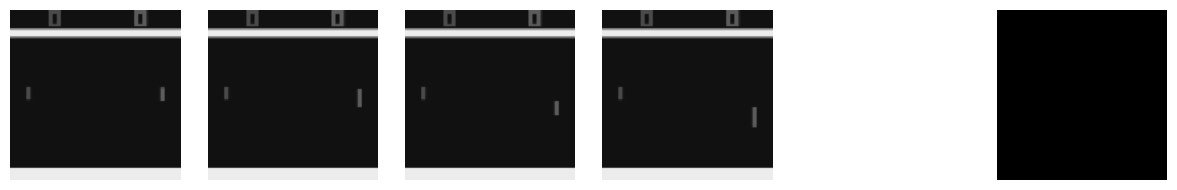

In [32]:
def display_single_channel(channel):
    
    if len(channel.shape) == 2:
        channel = np.reshape(channel, (channel.shape[0], channel.shape[1], 1))

    assert len(channel.shape) == 3, f"channel has a shape of {channel.shape}"
    image = np.repeat(channel, 3, axis=2)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def display_all_channels(observation):
    num_images = observation.shape[2]

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))

    for i in range(num_images):
        image = np.reshape(observation[:, :, i], (observation[:, :, i].shape[0], observation[:, :, i].shape[1], 1))
        image = np.repeat(image, 3, axis=2)

        axes[i].imshow(image)
        axes[i].axis('off')

    plt.tight_layout()
    # plt.show()

def display_observation(observations):
    assert len(observation.shape) == 3 and observation.shape[2] == 6, f"Observation should have 6 channels, but has shape {observation.shape}."
    display_all_channels(observation[:, :, :])
    display_all_channels(observation[:, :, 4:6]) 

selected_sample = samples[6]
name, observation, action, reward = deserialize_sample(selected_sample, "web_actor", action_space, observation_space)

display_all_channels(observation[:, :, :])
# display_single_channel(observation[:, :, 3])
# display_observation(observation)

In [33]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

observations = []
for sample in samples:
    name, observation, action, reward = deserialize_sample(sample, "web_actor", action_space, observation_space)
    observations.append(observation)

@widgets.interact(observations=fixed(observations), idx=(0, len(observations) - 1))
def display_observations(observations, idx=0):
    observation = observations[idx]
    assert len(observation.shape) == 3 and observation.shape[2] == 6, f"Observation should have 6 channels, but has shape {observation.shape}."
    display_all_channels(observation[:, :, :])



interactive(children=(IntSlider(value=0, description='idx', max=2616), Output()), _dom_classes=('widget-intera…

In [40]:
@widgets.interact(x=(0, 5))
def f(x=0):
    print(x)

interactive(children=(IntSlider(value=0, description='x', max=5), Output()), _dom_classes=('widget-interact',)…

## Same sample - different actor

Conclusion, both actors receive the exact same observation, with an indicator for the player to which it is destined to in the observation array itself.

web_actor observation:
web_actor action: 1
player_2 observation:
player_2 action: 5


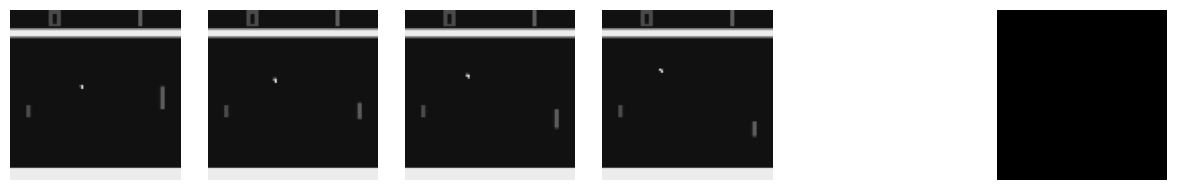

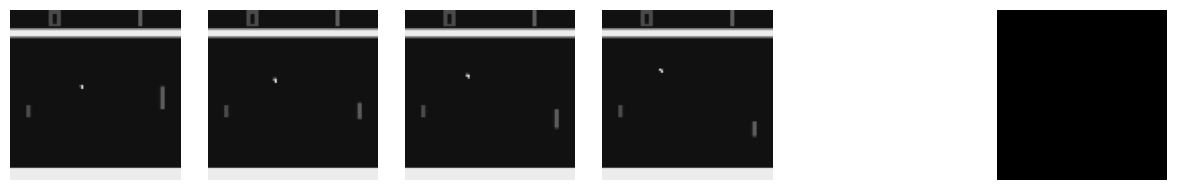

In [76]:
sample = samples[110]

web_name, web_observation, web_action, web_reward = deserialize_sample(sample, "web_actor", action_space, observation_space)
print(f"{web_name} observation:")
print(f"{web_name} action: {web_action}")
display_all_channels(web_observation[:, :, :])

name, observation, action, reward = deserialize_sample(sample, "player_2", action_space, observation_space)
print(f"{name} observation:")
print(f"{name} action: {action}")
display_all_channels(observation[:, :, :])



## Data Augmentation

### Mirroring Observations

In [41]:
name, observation, action, reward = deserialize_sample(sample, "web_actor", action_space, observation_space)

mirrored_obs = np.copy(observation)
mirrored_obs.


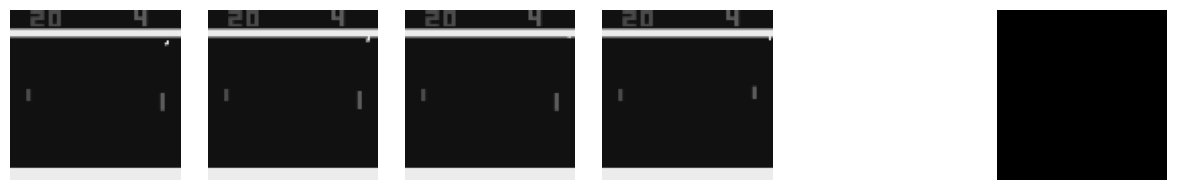

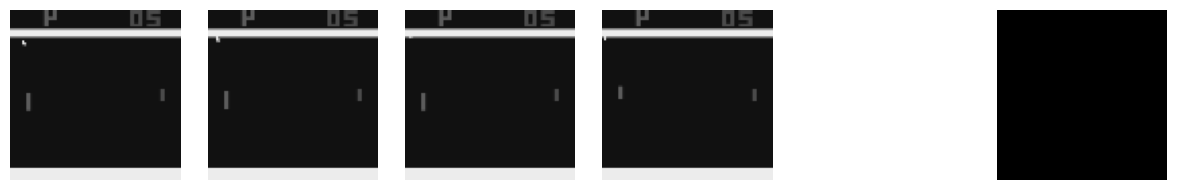

In [65]:
display_all_channels(observation[:, :, :])
display_all_channels(observation[:, ::-1, :])

In [53]:
observation[9:, ::-1, :].shape

(75, 84, 6)

## Adapt Observation to HF Hub Model

Required model input: (4, 84, 84)
Current observation size: (84, 84, 6)

In [96]:
observation = observation_space.deserialize(sample.actors_data["web_actor"].observation)
observation_tensor = torch.tensor(observation.value, dtype=torch.float) #.view(1, -1)

print(observation_tensor.size())

print(observation_tensor[:, :, :4].permute(2, 0, 1).size())

torch.Size([84, 84, 6])
torch.Size([4, 84, 84])
